# Lab-05: Visualizing tweets from the 2020 US presidential election

In [1]:
import os
import pandas as pd

# Dataset is a randomly sampled subset of: https://www.kaggle.com/manchunhui/us-election-2020-tweets
trump = pd.read_csv("2020_tweets_trump.csv", lineterminator='\n')
biden = pd.read_csv("2020_tweets_biden.csv", lineterminator='\n')

In [2]:
len(biden), len(trump)

(100000, 100000)

In [3]:
M = 10000
trump = trump.sample(n=M//2)
biden = biden.sample(n=M//2)

In [4]:
biden_tweets = biden['tweet'].tolist()
trump_tweets = trump['tweet'].tolist()

In [5]:
biden_tweets[3023]

'🔵 L’état du Vermont est gagné par #JoeBiden sans surprise.\n\n3 super délégués dans la hotte du candidat démocrate.\n\n#ElectionNight #ElectionDay https://t.co/ZhdGJvp2Om'

# Preprocessing pipeline

In [6]:
import re
from tqdm import tqdm
from typing import List

import spacy
from spacy.language import Language

pipeline_name = '2020ElectionTweets'


def camel_case_split(str):
    """ This function turns in #Biden2020 into Biden 2020 """
    return " ".join([wrd for wrd in re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str)])


@Language.component(pipeline_name)
def preprocess(doc):
    doc = [token for token in doc if not token.is_punct]
    # doc = [token for token in doc if not token.is_stop]
    doc = [token.text.lower().strip() for token in doc]
    doc = [token for token in doc if 0 < len(token) <= 12]
    return " ".join(doc)


class Pipeline:
    
    # http://emailregex.com/
    email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)
    *|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]
    |\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9]
    (?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}
    (?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:
    (?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""
    # replace = [ (pattern-to-replace, replacement),  ...]
    replace = [
        ("<[^>]*>", " "),
        (email_re, " "),                           # Matches emails
        (r"(?<=\d),(?=\d)", ""),                   # Remove commas in numbers
        (r"\d+", " "),                             # Map digits to special token <numbr>
        (r"[*\^\.$&@<>,\-/+{|}=?#:;'\"\[\]]", ""), # Punctuation and other junk
        (r"[\n\t\r]", " "),                        # Removes newlines, tabs, creturn
        (r"[^\x00-\x7F]+", ""),                    # Removes non-ascii chars
        (r"\\+", " "),                             # Removes double-backslashs
        (r"\s+n\s+", " "),                         # 'n' leftover from \\n
        (r"\s+", " ")                              # Strips extra whitespace
    ]
    
    def __init__(self):
        self.pipeline = spacy.load('en_core_web_sm')
        self.pipeline.add_pipe(pipeline_name);
        
    def __call__(self, *args, **kwargs):
        return self.transform(*args, **kwargs)

    def transform(self, doc: str):
        for repl in self.replace:
            doc = re.sub(repl[0], repl[1], doc)
        doc = camel_case_split(doc)
        return self.pipeline(doc)
    
pipeline = Pipeline();

In [7]:
from tqdm import tqdm

with tqdm(total=M//2) as bar:
    for i, (bt, tt) in enumerate(zip(biden_tweets, trump_tweets)):
        biden_tweets[i] = pipeline(bt)
        trump_tweets[i] = pipeline(tt)
        bar.update()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:07<00:00, 39.19it/s]


In [8]:
biden_tweets[3023]

'ltat vermont joe biden election night election day zhd g jvp om'

### Concatenate documents for vocab generation

In [9]:
all_tweets = biden_tweets + trump_tweets

## (20 pts) Task I: Train a Doc2Vec model (using the Gensim package) on tweets from the 2020 US presidential election

*Docs*: 

* https://radimrehurek.com/gensim/models/doc2vec.html

*Useful tutorials*: 

* https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial 
* https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

### Hyperparameters

In [10]:
# Change as needed
K = 20
word_frequency_threshold = 2
epochs = 10
lr = 0.01

In [11]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

model = Doc2Vec(vector_size=K, min_count=word_frequency_threshold, epochs=epochs)

C:\Users\sangi\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [12]:
# Your code goes here
print("# of Biden Tweets: ", len(biden_tweets))
print("# of Trump Tweets: ", len(trump_tweets))

# of Biden Tweets:  5000
# of Trump Tweets:  5000


In [13]:
tweets_split = [tweet.split() for tweet in all_tweets]

In [14]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tweets_split)]
model = Doc2Vec(documents, vector_size=K, min_count=word_frequency_threshold, epochs=epochs)

## (10  pts) Task II: Evaluate your model by computing the most similar documents (tweets) to new (perhaps made up) tweets

In [15]:
# Template function
def find_similar_tweets(tweet, top_n=10):
    doc = tweet.split()
    doc_vector = model.infer_vector(doc)
    sims = model.dv.most_similar([doc_vector], topn=top_n)
    return sims

In [16]:
# Your code goes here

find_similar_tweets("this is the worst trade deal in the history of trade deals")

[(2103, 0.86579829454422),
 (7470, 0.8585988283157349),
 (3496, 0.8570613265037537),
 (396, 0.8556974530220032),
 (3959, 0.8509414196014404),
 (5905, 0.8418883681297302),
 (862, 0.8376309871673584),
 (6616, 0.8338011503219604),
 (63, 0.8317818641662598),
 (2498, 0.8287592530250549)]

## (10 pts extra credit) Task III: Produce a scatter plot of the compressed document embeddings (2D or 3D)

*Useful resources*:

* http://projector.tensorflow.org/

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Your code goes here
all_vecs = []
for i in range(len(all_tweets)):
    all_vecs.append(model.dv[i]) # very inefficient, but it works

pca = PCA(n_components=2)
pca_vals = pca.fit_transform(all_vecs)
pca_df = pd.DataFrame(pca_vals, columns=['x', 'y'])
pca_df.head()

,x,y
0,-0.202485,0.000452
1,0.018897,0.032196
2,0.024046,0.002093
3,-0.310169,0.011896
4,0.185689,0.010828


C:\Users\sangi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sangi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

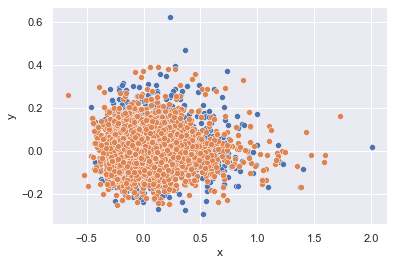

In [33]:
sns.scatterplot(pca_df['x'][:len(biden_tweets)], pca_df['y'][:len(biden_tweets)])
sns.scatterplot(pca_df['x'][len(biden_tweets):], pca_df['y'][len(biden_tweets):])
# This is a shortcut because I know how the all_tweets vector was created!